In [ ]:
! pip install pandas
! pip install seaborn
! pip install sklearn
! pip install tensorflow
! pip install -q -U keras-tuner

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import kerastuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband
from kerastuner.tuners import BayesianOptimization 
from tensorflow.keras import backend as K

In [ ]:
df = pd.read_csv('V5_final_dataset.csv', index_col=0)

In [ ]:
X = df.drop(columns=['Glu (vein)'])
y = df['Glu (vein)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_s = preprocessing.scale(X_train)
X_test_s = preprocessing.scale(X_test)

# The model

In [6]:

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


def build_model(features_count: int):
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[features_count]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
  return model

EPOCHS = 1000
BATCH_SIZE = 64

EARLY_STOPPING = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
model = build_model(X_train_s.shape[1])

In [ ]:
model.summary()

In [ ]:
# training_generator = BalancedBatchGenerator(
#         X_train_s, y_train,
#         batch_size=BATCH_SIZE,
#         random_state=42)
# model.fit(
#     training_generator,
#     batch_size=BATCH_SIZE,
#     epochs=EPOCHS,
#     callbacks=[EARLY_STOPPING],
#     validation_split=0.1,
#     verbose=0)
model.fit(X_train_s, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = 0.1, verbose=0, callbacks=[EARLY_STOPPING])
test_predictions_weighted = model.predict(X_test_s, batch_size=BATCH_SIZE)

In [ ]:
loss, mae, mse = model.evaluate(X_test_s, y_test, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

In [ ]:
plt.figure(figsize=(15,5)) 
plt.plot(y_test.tolist(), label='Y test')
plt.plot(test_predictions_weighted, label='Neural network')

In [16]:
from kerastuner import HyperModel

class RegressionHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    def build(self, hp):
        model = keras.Sequential()
        model.add(
            layers.Dense(
                units=hp.Int('units_1', 16, 128, 16, default=16),
                activation=hp.Choice(
                    'dense_activation_1',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                input_shape=input_shape
            )
        )
        
        model.add(
            layers.Dropout(
                hp.Float(
                    'dropout_1',
                    min_value=0.0,
                    max_value=0.4,
                    default=0.05,
                    step=0.05)
            )
        )

        model.add(
            layers.Dense(
                units=hp.Int('units_2', 64, 256, 32, default=64),
                activation=hp.Choice(
                    'dense_activation_2',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu')
            )
        )
        
        model.add(
            layers.Dropout(
                hp.Float(
                    'dropout_2',
                    min_value=0.0,
                    max_value=0.2,
                    default=0.04,
                    step=0.04)
            )
        )

        model.add(
            layers.Dense(
                units=hp.Int('units_3', 16, 128, 16, default=16),
                activation=hp.Choice(
                    'dense_activation_3',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu')
            )
        )
        
        model.add(
            layers.Dropout(
                hp.Float(
                    'dropout_3',
                    min_value=0.0,
                    max_value=0.2,
                    default=0.04,
                    step=0.04)
            )
        )
        
        model.add(layers.Dense(1))
        
        model.compile(
            optimizer='adam', loss='mse', metrics=['mse', 'mae']
        )
        
        return model

In [17]:
input_shape = (X_train_s.shape[1],)
hypermodel = RegressionHyperModel(input_shape)

In [ ]:
tuner = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2)


In [ ]:
tuner = Hyperband(
            hypermodel,
            max_epochs=5,
            objective='mse',
            seed=42,
            executions_per_trial=2
        )

In [18]:
tuner = BayesianOptimization(
            hypermodel,
            objective='mse',
            max_trials=10,
            seed=42,
            executions_per_trial=2
        )


In [19]:
tuner.search(X_train_s, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0, callbacks=[EARLY_STOPPING])
best_model = tuner.get_best_models(num_models=1)[0]
predicted_y = best_model.predict(X_test_s)
loss, mse, mae = best_model.evaluate(X_test_s, y_test)

INFO:tensorflow:Oracle triggered exit
192/192 [==============================] - ETA: 0s - loss: 11.5983 - mse: 11.5983 - mae: 2.675 - ETA: 0s - loss: 10.1223 - mse: 10.1223 - mae: 2.348 - 0s 517us/step - loss: 10.1535 - mse: 10.1535 - mae: 2.3596


In [ ]:
mae

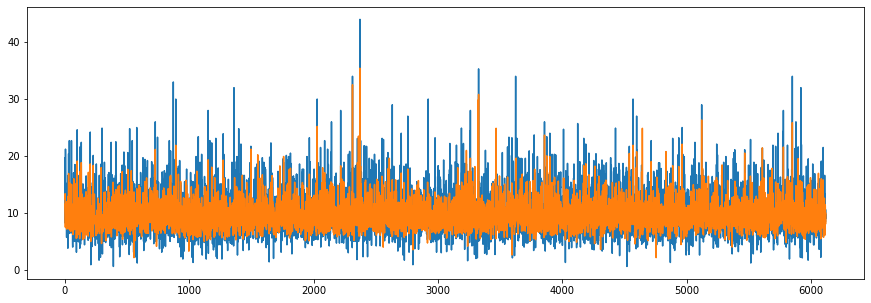

In [20]:
plt.figure(figsize=(15,5)) 
plt.plot(y_test.tolist(), label='Y test')
plt.plot(predicted_y, label='Neural network')

In [ ]:
tuner.results_summary()

In [21]:
import sklearn
sklearn.metrics.r2_score(y_test, predicted_y)

0.38157956817989547

In [ ]:
print(predicted_y)